<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Image Generation
In this notebook we are going to inspect how to use AWS Bedrock to generate images using the [Amazon Titan Image Generator](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-image-models.html)!

## API Connection
Let's directly use the bedrock runtime

In [3]:
import boto3
import json
bedrock_runtime = boto3.client(aws_access_key_id="",
                               aws_secret_access_key="",
                               region_name="us-east-1",
                               service_name='bedrock-runtime')


### Amazon Titan image Parameters
Amazon Titan models accept the following [parameters](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html) for text to image generation:

- **taskType**
  - Value: `"TEXT_IMAGE"`  // Amazon Titan can also perform inpainting, outpainting and variations
- **textToImageParams**
  - `text`: String (Required)
      - Image Generation prompt 
  - `negativeText`: String (Optional)
      - What you don't want to include in the image (e.g violence)
- **imageGenerationConfig**
  - `numberOfImages`: Integer (Range: 1 to 5)
  - `quality`: String (Options: `"standard"` / `"premium"`)
  - `height`: Integer (Supported height max: 1024)
  - `width`: Integer (Supported width max: 1024)
  - `cfgScale`: Float (Range: 1.0 (exclusive) to 10.0)
  - `seed`: Integer (Range: 0 to 214783647)
   
Thus, the model expects the following jsonified request body:
```
(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "prompt",       // Required
            "negativeText": "text"  // Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   // Range: 1 to 5 
            "quality": "standard", // Options: standard/premium
            "height": 1024,        // Supported height max 
            "width": 1024,         // Supported width max
            "cfgScale": 8.0,       // Range: 1.0 (exclusive) to 10.0
            "seed": 0              // Range: 0 to 214783647
        }
    }
)
```

Let's generate a cartoon of Napoleon on a hoverboard using `amazon.titan-image-generator-v1`!

In [4]:
prompt = "A cartoon of emperor Napoleon on a hoverboard."

In [5]:
request_body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,       
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  
            "quality": "premium",  # standard or premium
            "height": 512,       
            "width": 512,
            "cfgScale": 8,
            "seed": 0             
        }
    }
)


In [6]:
response = bedrock_runtime.invoke_model(body=request_body, modelId="amazon.titan-image-generator-v1")

In [7]:
response_body = json.loads(response.get('body').read())

The response structure is as follows:

- **images**
  - An array of images.
  - One image for each requested image.
- **error**
  - *None* if no error occurred

To view the generated image we need to convert the base64 encoded image to a png first:

1. Convert it to a base64 binary string
2. Write this binary data to a png
3. Read the Image to visualize it

In [11]:
import base64
from PIL import Image

In [12]:
base64_image_data = base64.b64decode(response_body["images"][0])

In [15]:
file_path = "napoleon.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data)



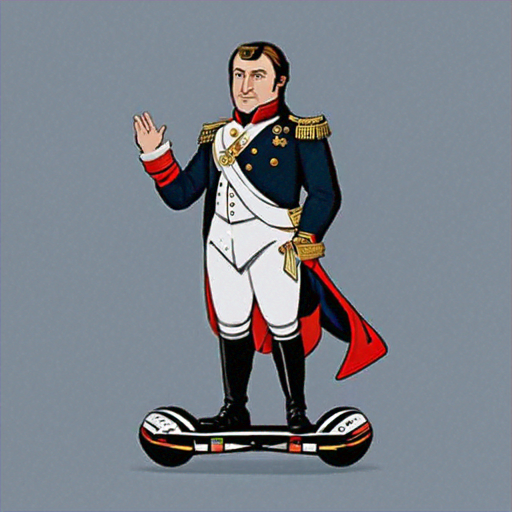

In [16]:
Image.open("napoleon.png")

### Image Variation
We can also introduce some variations to our image using bedrock! <br />
("Image variation uses an image and an optional text prompt as input. It generates a new image that preserves the content of the input image, but variates its style and background.")

The request body is as follows:
```
{
         "taskType": "IMAGE_VARIATION",
         "imageVariationParams": {
             "text": "Modernize the house, photo-realistic, 8k, hdr",  // Optional
             "negativeText": "bad quality, low resolution, cartoon",   // Optional
             "images": [input_image],                                  // One image is required
         },
         "imageGenerationConfig": {
             "numberOfImages": 1,
             "quality": "premium",  // Note that you can cho
             "height": 512,
             "width": 512,
             "cfgScale": 8.0
         }
     }
```
It expects the image as a string, thus we need to convert our previously stored image back to its original form:



In [17]:
with open("napoleon.png", "rb") as f:
    content = f.read()
    image_string = base64.b64encode(content).decode("utf-8")


In [18]:
request_body_variation = json.dumps({
         "taskType": "IMAGE_VARIATION",
         "imageVariationParams": {
             "text": "photo-realistic, 4k, hdr",
             "images": [image_string],  # Use the original image string, not the base64 bytes data!
         },
         "imageGenerationConfig": {
             "numberOfImages": 1,
             "quality": "premium",
             "height": 512,
             "width": 512,
             "cfgScale": 9
         }
     }
)


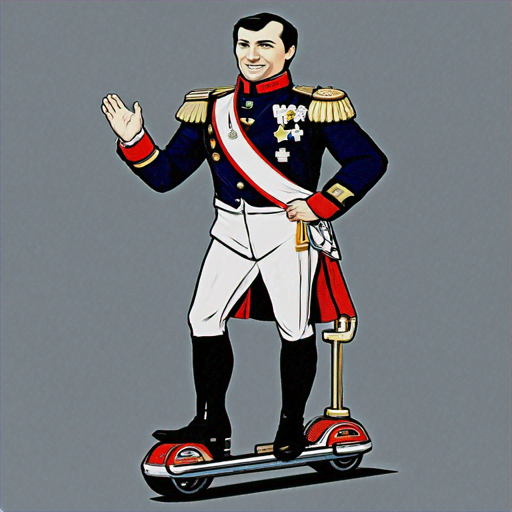

In [19]:
response_variation = bedrock_runtime.invoke_model(body=request_body_variation, modelId="amazon.titan-image-generator-v1")
response_variation_body = json.loads(response_variation.get('body').read())
base64_image_data_variation = base64.b64decode(response_variation_body["images"][0])

file_path = "napoleon_2.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data_variation)
Image.open("napoleon_2.png")


As you can see, it cannot create a totally new image but only introduce some minor alteration, lige making the face look a tiny bit more real